In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [3]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3, linewidth=80)

## Q-Learning

In [4]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)



In [5]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 50/500, Reward -1000.0, Average Max Reward: -990.8, Total steps 1000.0, Epsilon: 0.72, Alpha: 0.10, Time 0.072
Episode 100/500, Reward -1000.0, Average Max Reward: -996.0, Total steps 1000.0, Epsilon: 0.54, Alpha: 0.10, Time 0.072
Episode 150/500, Reward -660.0, Average Max Reward: -888.2, Total steps 660.0, Epsilon: 0.37, Alpha: 0.10, Time 0.076
Episode 200/500, Reward -280.0, Average Max Reward: -261.6, Total steps 280.0, Epsilon: 0.19, Alpha: 0.10, Time 0.023
Episode 250/500, Reward -878.0, Average Max Reward: -266.5, Total steps 878.0, Epsilon: 0.01, Alpha: 0.10, Time 0.068
Episode 300/500, Reward -273.0, Average Max Reward: -225.9, Total steps 273.0, Epsilon: 0.01, Alpha: 0.10, Time 0.038
Episode 350/500, Reward -310.0, Average Max Reward: -354.2, Total steps 310.0, Epsilon: 0.01, Alpha: 0.10, Time 0.024
Episode 400/500, Reward -189.0, Average Max Reward: -221.0, Total steps 189.0, Epsilon: 0.01, Alpha: 0.10, Time 0.020
Episode 450/500, Reward -185.0, Average Max Reward: -

## Con-RL

In [45]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step
env.spec.max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 2, 
    "e_w":0.05, 
    "e_n":0.05, 
    "l":10, 
    "a":0.5, 
    "b":0.95,
    "k":1000.0, 
    "max_nodes": 10, 
    "max_age": 200
}

In [49]:
stats_cr= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "global_error":     np.zeros((num_episodes, env.action_space.n)),
        "mlgng_nodes":      [],
        "best_actions":     [],

}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
support = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)
conrl.init_support(support)
conrl.init_mlgng(**mlgng_params)

conrl.train(env, num_episodes, stats_cr)


Episode 50/500, Average Max Reward: -947.7, Global Error: 0.00, Total steps 1000.0, Epsilon: 0.72, Alpha: 0.10, Time 0.359
	 MLGNG nodes per action layer: 0 0 2
Episode 100/500, Average Max Reward: -870.4, Global Error: 46.58, Total steps 1000.0, Epsilon: 0.54, Alpha: 0.10, Time 0.693
	 MLGNG nodes per action layer: 3 3 4
Episode 150/500, Average Max Reward: -364.8, Global Error: 24.79, Total steps 306.0, Epsilon: 0.37, Alpha: 0.10, Time 0.295
	 MLGNG nodes per action layer: 8 8 10
Episode 200/500, Average Max Reward: -438.1, Global Error: 19.39, Total steps 246.0, Epsilon: 0.19, Alpha: 0.10, Time 0.226
	 MLGNG nodes per action layer: 10 10 10
Episode 250/500, Average Max Reward: -733.6, Global Error: 19.87, Total steps 1000.0, Epsilon: 0.01, Alpha: 0.10, Time 0.802
	 MLGNG nodes per action layer: 10 10 10
Episode 300/500, Average Max Reward: -208.5, Global Error: 20.46, Total steps 208.0, Epsilon: 0.01, Alpha: 0.10, Time 0.214
	 MLGNG nodes per action layer: 10 10 10
Episode 350/500, 

## Statistics

In [8]:
from src.plotting import *

act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))


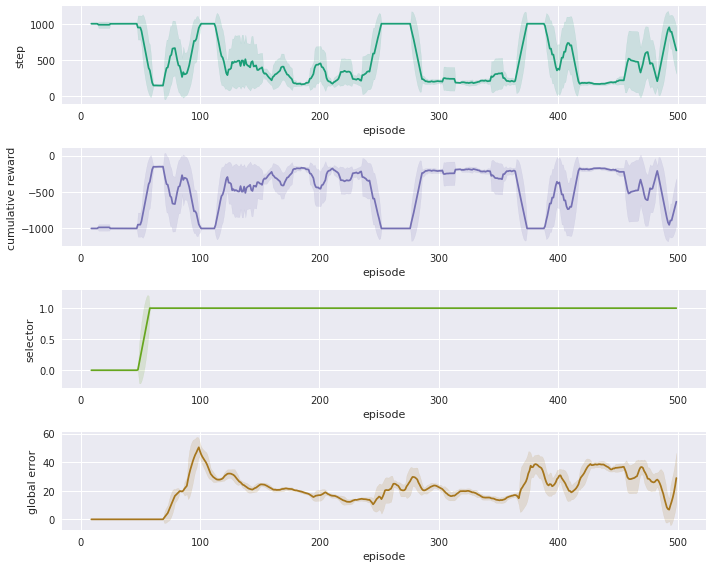

In [50]:
to_plot = ["step", "cumulative_reward", "global_error", "selector"]

stats_to_plot = {key: value for key, value in stats_cr.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
plot_stats(stats_to_plot, figsize=(10, 8))

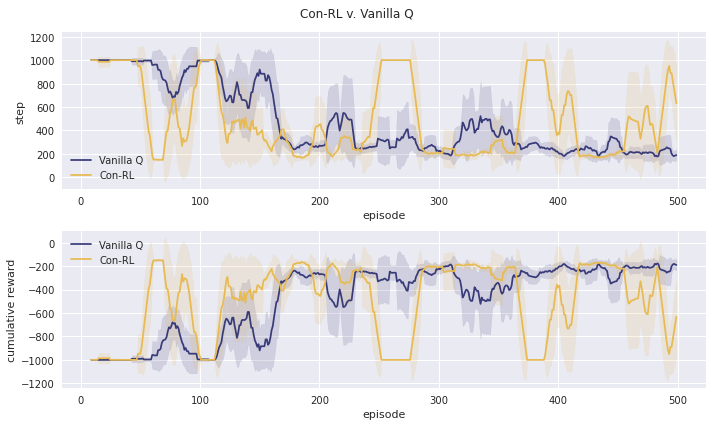

In [52]:
to_plot = ["step", "cumulative_reward"]
plot_stats_comparison({
    "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
},
title="Con-RL v. Vanilla Q",
rolling_window=10)

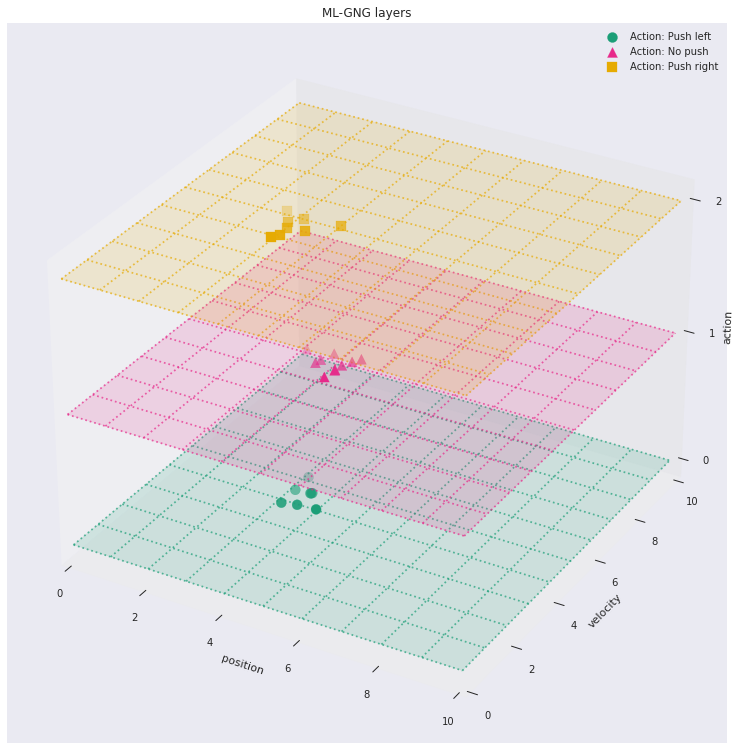

In [53]:
nodes = conrl.mlgng.get_nodes()

plot_nodes_3d(
            nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,   
            axis_names=["position", "velocity", "action"])

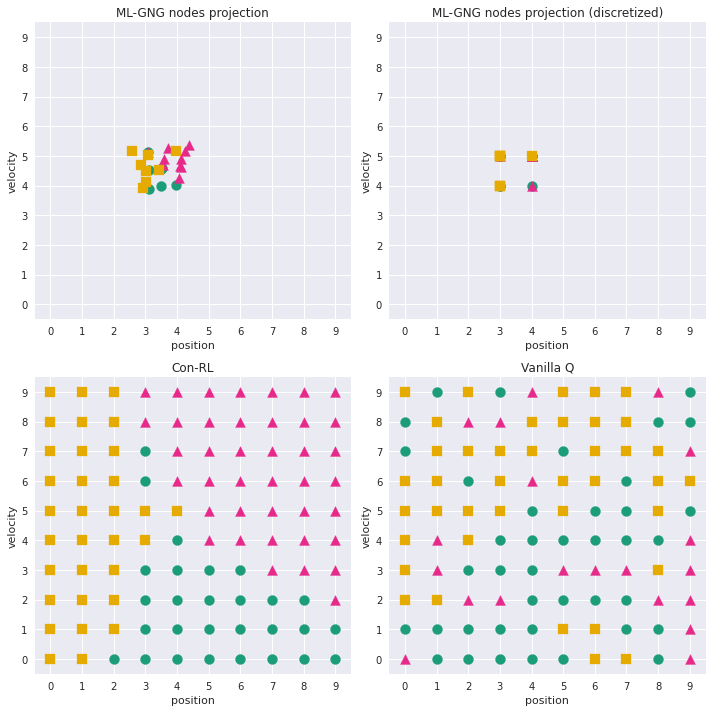

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection (discretized)",
            round=True,
            def_plot=(fig, ax[1]),)

project_nodes(nodes=conrl.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL",
            def_plot=(fig, ax[2]))

project_nodes(nodes=q_agent.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q",
            def_plot=(fig, ax[3]))

fig.tight_layout()

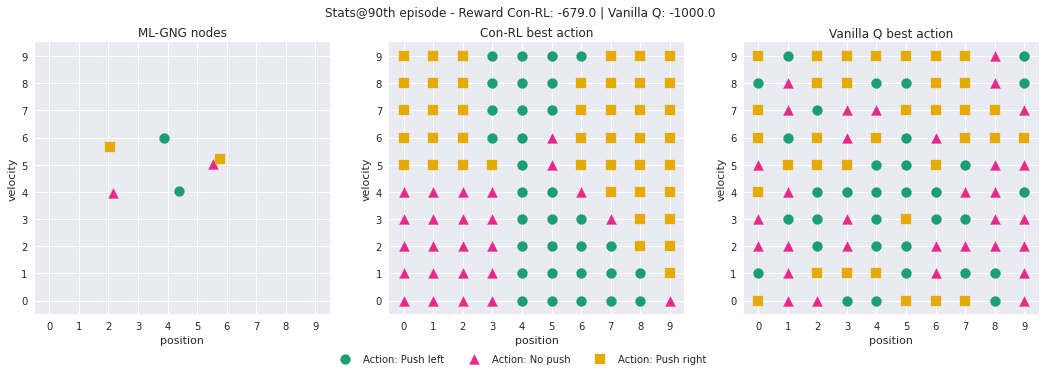

In [55]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
ax = ax.flatten()

ep = 90
fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL best action",
            round=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=stats_q["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q best action",
            round=True,
            labels=True,
            def_plot=(fig, ax[2]),
            legend=False)
fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=3)

In [56]:
act_symbol_plotly = {0:0, 1:5, 2:1}
act_color_plotly = act_color.copy()
act_color_plotly[:, 0:-1]=act_color_plotly[:, 0:-1]*255

In [64]:
plot_nodes_changes(stats_cr["mlgng_nodes"][230:250], 
                rewards=stats_cr["cumulative_reward"][230:250],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=1)

In [57]:
plot_nodes_changes(stats_cr["mlgng_nodes"], 
                rewards=stats_cr["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(stats_cr["best_actions"], 
                rewards=stats_cr["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)

In [58]:
stats_cr["best_actions"][np.argmax(stats_cr["cumulative_reward"])][-1].reshape(state_size).astype(int)

array([[0, 0, 0, 0, 2, 2, 1, 2, 2, 2],
       [0, 0, 0, 0, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 2, 1, 2, 2, 2, 0],
       [0, 0, 0, 0, 1, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 2, 2, 0, 0],
       [0, 0, 0, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

In [59]:
# Test MLGNG simplification from near optimal policy
good_policy = stats_cr["best_actions"][np.argmax(stats_cr["cumulative_reward"])][-1].reshape(state_size).astype(int)

stats_opt= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes)
}


for episode in range(num_episodes):
        done = False
        step = 0
        cumulative_reward = 0

        start = time.time()
        state = env.reset()

        while not done:
            action = good_policy[state]
            next_state, reward, done, _ = env.step(action)
            state = next_state
            
            cumulative_reward += reward
            step+=1

        stats_opt["cumulative_reward"][episode] = cumulative_reward
        stats_opt["step"][episode] = step 

            
        end = time.time() - start
        if (episode+1) % 50 == 0:
            print("Episode {}/{}, Average Max Reward: {}, Total steps {}, Time {:.3f}".format(
                episode+1, 
                num_episodes, 
                stats_opt["cumulative_reward"][episode-10:episode].mean(),
                stats_opt["step"][episode],
                end))

Episode 50/500, Average Max Reward: -185.2, Total steps 200.0, Time 0.015
Episode 100/500, Average Max Reward: -164.6, Total steps 202.0, Time 0.010
Episode 150/500, Average Max Reward: -175.0, Total steps 125.0, Time 0.006
Episode 200/500, Average Max Reward: -175.6, Total steps 123.0, Time 0.012
Episode 250/500, Average Max Reward: -155.5, Total steps 156.0, Time 0.007
Episode 300/500, Average Max Reward: -166.3, Total steps 175.0, Time 0.008
Episode 350/500, Average Max Reward: -168.3, Total steps 207.0, Time 0.010
Episode 400/500, Average Max Reward: -169.4, Total steps 212.0, Time 0.014
Episode 450/500, Average Max Reward: -185.0, Total steps 155.0, Time 0.008
Episode 500/500, Average Max Reward: -172.1, Total steps 123.0, Time 0.006


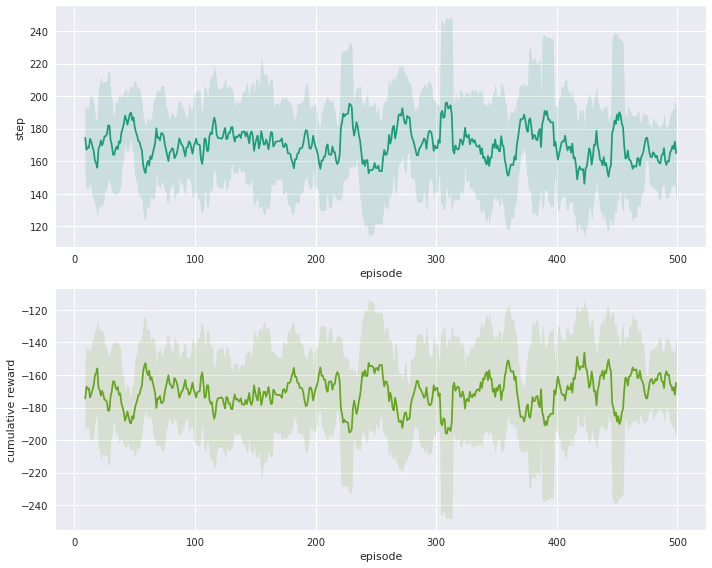

In [60]:
plot_stats(stats_opt, figsize=(10, 8))

In [61]:
class FakeSupport:
    def __init__(self, policy_table):
        self.policy_table = policy_table
        self.epsilon = 0.9
        self.epsilon_decay_rate = 0.0
        self.min_epsilon = 0.01
        self.alpha = 0.0

    def decay_param(self, param):
        decay = getattr(self, param+"_decay_rate", 0)
        value = getattr(self, param, 0)
        min_value = getattr(self, "min_"+param, 0)
        setattr(self, param, max(value-decay, min_value))

    def update(self, *args):
        pass
    
    def policy(self, state, **kwargs):
        return self.policy_table[state]
    

In [62]:
q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

stats_cr2= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "global_error":     np.zeros((num_episodes, env.action_space.n)),
        "mlgng_nodes":      [],
        "best_actions":     [],

}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
support = FakeSupport(good_policy)
conrl.init_support(support)
conrl.init_mlgng(**mlgng_params)
conrl.train(env, num_episodes, stats_cr2)



Episode 50/500, Average Max Reward: -229.1, Global Error: 4.20, Total steps 200.0, Epsilon: 0.90, Alpha: 0.00, Time 0.205
	 MLGNG nodes per action layer: 10 5 9
Episode 100/500, Average Max Reward: -235.1, Global Error: 3.00, Total steps 225.0, Epsilon: 0.90, Alpha: 0.00, Time 0.276
	 MLGNG nodes per action layer: 10 10 10
Episode 150/500, Average Max Reward: -202.7, Global Error: 4.14, Total steps 295.0, Epsilon: 0.90, Alpha: 0.00, Time 0.292
	 MLGNG nodes per action layer: 10 4 10
Episode 200/500, Average Max Reward: -254.3, Global Error: 3.75, Total steps 234.0, Epsilon: 0.90, Alpha: 0.00, Time 0.229
	 MLGNG nodes per action layer: 10 9 10
Episode 250/500, Average Max Reward: -188.0, Global Error: 3.86, Total steps 228.0, Epsilon: 0.90, Alpha: 0.00, Time 0.329
	 MLGNG nodes per action layer: 10 5 10
Episode 300/500, Average Max Reward: -262.1, Global Error: 3.10, Total steps 296.0, Epsilon: 0.90, Alpha: 0.00, Time 0.264
	 MLGNG nodes per action layer: 10 10 10


KeyboardInterrupt: 

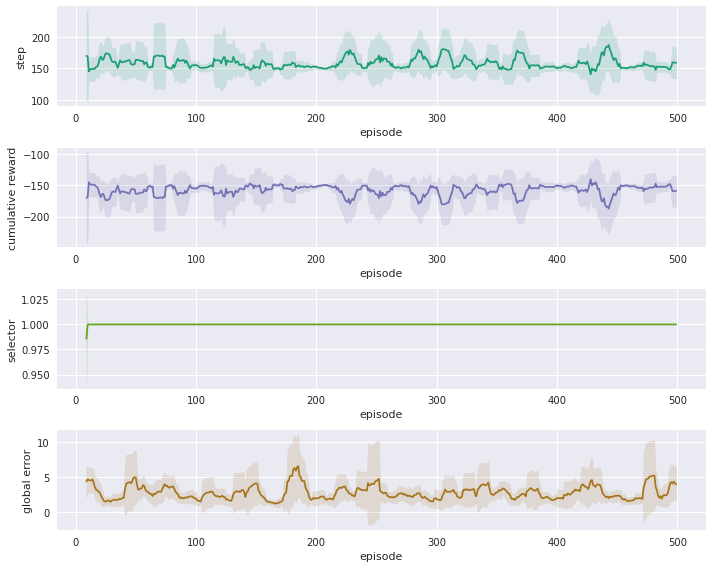

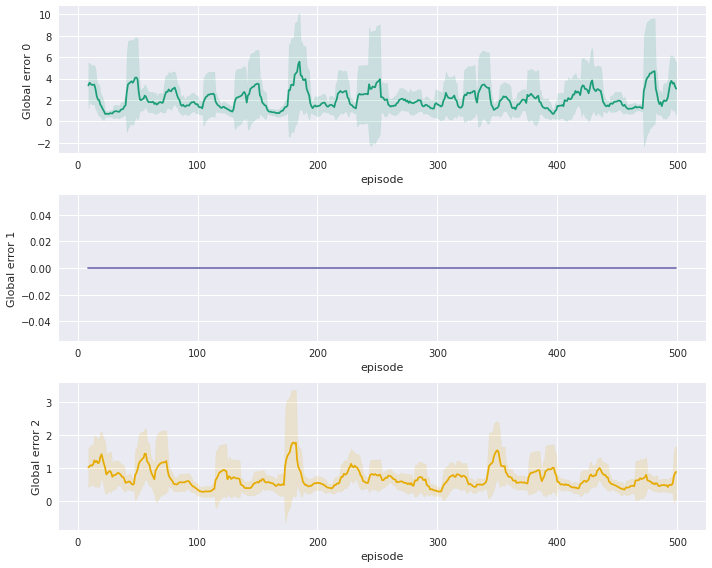

In [22]:
to_plot = ["step", "cumulative_reward", "global_error", "selector"]

stats_to_plot = {key: value for key, value in stats_cr2.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
plot_stats(stats_to_plot, figsize=(10, 8))

stats_to_plot = {"Global error {}".format(idx): stats_cr2["global_error"][:, idx] for idx in range(env.action_space.n)}
plot_stats(stats_to_plot, figsize=(10, 8))

plot_nodes_changes(stats_cr2["mlgng_nodes"], 
                rewards=stats_cr2["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(stats_cr2["best_actions"], 
                rewards=stats_cr2["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)